# ADA Project: Welcome to the final analysis of **Amercian Influence in the Cinema industry**

## Authors
- Group Name: ADACTYLOUS
    - Chloé Bouchiat
    - Claire Pinson
    - Germana Sergi
    - Luca Soravia
    - Marlen Stöckli

## Notebook's structure A MODIFIER POUR P3
- Main librairies and specific functions from the utils folder
- Our analysis workflow with a markdown cell explaining each code cell
- The notebook reads as follow:
    - movie.metadata enriched by IMDB ratings (coming from the IMDb non commercial datasets ([IMDb](https://developer.imdb.com/))
        - General information about the dataset (i.e. basic stats, first visualization)
        - Exploratory analysis of the dataset according to our research questions
    - character.metadata enriched with wikipedia actor's nationality ([DBpedia](https://www.dbpedia.org/about/))
        - General information about the dataset (i.e. basic stats, first visualization)
        - Exploratory analysis of the dataset according to our research questions

#### Recall of the repository structure:
```
📁 ada-2024-project-adactylous
│
├── 📄 results.ipynb (where all ours plots and analysis are)
├── 📄 .gitignore (what is ignored during push and pull requests)
├── 📄 requirements.txt (install into your environment)
├── 📄 README.md
│
├── 📁 data
       │── 📄 actor_metadata_CMU.csv
       │── 📄 movie_metadata_CMU_IMDB.csv
       │── 📄 nationality.csv
       │── 📄 personas_metadata_CMU.csv
       │── 📄 plot_summaries_CMU.csv
├── 📁 src
    ├── 📁 data
    ├── 📁 models
    ├── 📁 scripts
        │── 📄 datasets_cleaner.py
        │── 📄 nationality_importer.py
    ├── 📁 utils
└── 📁 tests
``` 
**NOTE**: Other empty folders and .py files will be filled up later on during the project.

In [1]:
# Import the needed libarairies
import warnings # to ignore pandas version warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math
import plotly.express as px

from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_ind, spearmanr # to implement statistical tests
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans # for actors analysis
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score

np.random.seed = 0

############# Add more libraries if needed

In [2]:
########################### Read datasets from repository's data folder ############################
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd = pd.read_table('data/actor_metadata_CMU.csv', sep=',')


In [3]:
# Set a global background theme for all our plots and ignore warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

### Movie Sucess index

In [4]:
# Create function to encode multivariate features

def multi_label_binarizer(df, col, k):
    # df : input data frame
    # col : name of the column with multi labels (string) 
    # return : dataframe with the column split into one-hot encoder

    # split cells into lists of labels, this will allow the correct labels to be stored
    df[col] = df[col].fillna('').str.split(',')

    # Process the dataset for a linear regression
    # Since the columns of genres and countries contains more that one label, we use the function MultiLabelBinarizer 
    # (pd.get_dummies does not work correctly and we get dozen of thousands of columns)
    # (found on : https://www.kaggle.com/discussions/questions-and-answers/66693)
    #instantiating MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    #Encode the multilabel data in MLB Format
    df_temporary = mlb.fit_transform(df[col])
    # transform to Dataframe to concat with original X dataset. We should specify the columns names (MultiLabelBinarizer stored them)
    df_temporary = pd.DataFrame(df_temporary, columns=mlb.classes_, index=df.index)
    

    # Drop rare features (i.e. features that are positive in less than k movies of the dataset), except for actors
    p=0
    if k!=0:
        for feature in mlb.classes_:
            if len(df_temporary[df_temporary[feature]==1])<k:
                p+=1
                df_temporary=df_temporary.drop(columns=[feature])

        print(f'For the {col} feature, {p} categories were dropped.')
   

    # Merge the processed countries will the training variables
    df = pd.concat([df, df_temporary], axis=1)

    # Drop column with the names of all countries aggregated
    df = df.drop(columns=[col])

    return df

In [5]:
# Grouping actors' names for each movie

# https://moncoachdata.com/blog/groupby-de-pandas/
# as_index=False so the column wiki_movie_ID is not used as index and we can therefore use it to access the data 
actors_movie_mtd=actor_mtd.groupby("wiki_movie_ID", as_index=False).agg(
   actors = pd.NamedAgg("actor_name","unique")
)


In [6]:
# Add the list of actors' names to the movie_mtd dataframe
movie_actors_mtd=movie_mtd.join(actors_movie_mtd, how='left', on='wiki_movie_ID', lsuffix='_left')



In [7]:
# Reshape the content of the 'actors' column to have a string containg all actors' names

#movie_actors_mtd=movie_actors_mtd.dropna(subset='actors')

def funct(x):
    # filter nan values and replace them with 0
    if isinstance(x,float):
        return 'no actor specified'
    # if actor's names are given, shape them in a string, separated with commas, 
    # so the multilabel binarizer could work latter
    else :
        string_of_names=str()
        for name in x :
            string_of_names+=str(name)+','
        return string_of_names[:-1]

movie_actors_mtd['actors']=movie_actors_mtd['actors'].apply(lambda x : funct(x))
#movie_actors_mtd_2[movie_actors_mtd_2['wiki_movie_ID_left']==44218]['actors']


In [8]:
movie_actors_mtd['actors'].apply(lambda x: type(x))
print(movie_actors_mtd[movie_actors_mtd['actors']!='no actor specified']['actors'])

498      Richard Bakalyan,Sidney Poitier,Bobby Darin,Ho...
1328                                             Clara Bow
1790     J. R. Bourne,Paulo Costanzo,Steph Song,Aidan D...
1804     Raymond Hackett,Colleen Moore,Edward Martindel...
1837     Kenneth MacDonald,Curly Howard,Fred Kelsey,Snu...
                               ...                        
80715                    Vera Miles,Jack Elam,Gordon Scott
80794                                        William Lucas
80803    Saravanan Sivakumar,Vivek,Amala Paul,Hansika M...
80807                       Mukesh,Bhama,Jagathi Sreekumar
81702    Fisher Stevens,Charlotte Rampling,Bill Pullman...
Name: actors, Length: 297, dtype: object


In [9]:
# Names of all possible variables for the linear regression

print(movie_actors_mtd.columns)


Index(['wiki_movie_ID_left', 'freebase_movie_ID', 'title', 'release_date',
       'box_office', 'runtime', 'languages', 'countries', 'genres_CMU',
       'release_year', 'genres_IMDB', 'averageRating', 'numVotes',
       'wiki_movie_ID', 'actors'],
      dtype='object')


In [10]:
# Choose variables on which we'll train to Linear regression
features=['box_office', 'languages', 'runtime', 'genres_CMU','release_year', 'actors', 'countries']
features_drop_na=['box_office', 'languages', 'runtime', 'genres_CMU','release_year','countries']
# multilabel feature to encode latter
features_multilabels=[ 'languages', 'genres_CMU', 'actors', 'countries']

########################################### Remove NaNs #################################################
# dataset of movies with which we'll make predictions for statistics (without calculating any king of accuracy)
movie_mtd_topredict=movie_actors_mtd.dropna(subset=features_drop_na)

#dataset to train and test the model
movie_mtd_ratings=movie_actors_mtd.dropna(subset='averageRating')
# We choose first to drop any line with NaN for any of the attributes
movie_mtd_ratings=movie_mtd_ratings.dropna(subset=features_drop_na)
print(f'The dataset that contains the ratings has a lenth of {len(movie_mtd_ratings)} movies')


#preprocessing => move to appropriate file
movie_mtd_ratings['countries']=movie_mtd_ratings['countries'].str.replace(', ',',')
movie_mtd_ratings['countries']=movie_mtd_ratings['countries'].str.lower()
movie_mtd_ratings['languages']=movie_mtd_ratings['languages'].str.replace(', ',',')
movie_mtd_ratings['languages']=movie_mtd_ratings['languages'].str.lower()
movie_mtd_ratings['genres_IMDB']=movie_mtd_ratings['genres_IMDB'].str.lower()
movie_mtd_ratings['genres_CMU']=movie_mtd_ratings['genres_CMU'].str.lower()
movie_mtd_ratings['genres_CMU']=movie_mtd_ratings['genres_CMU'].str.replace(', ',',')

movie_mtd_topredict['countries']=movie_mtd_topredict['countries'].str.replace(', ',',')
movie_mtd_topredict['countries']=movie_mtd_topredict['countries'].str.lower()
movie_mtd_topredict['languages']=movie_mtd_topredict['languages'].str.replace(', ',',')
movie_mtd_topredict['languages']=movie_mtd_topredict['languages'].str.lower()
movie_mtd_topredict['genres_IMDB']=movie_mtd_topredict['genres_IMDB'].str.lower()
movie_mtd_topredict['genres_CMU']=movie_mtd_topredict['genres_CMU'].str.lower()
movie_mtd_topredict['genres_CMU']=movie_mtd_topredict['genres_CMU'].str.replace(', ',',')
print(f'(Length of dataset to make predictions at the end of this notebook: {len(movie_mtd_topredict)})')
print('\n')
# get rid of movies where 'france' is present in the language column ! (causes 2 columns 'france' after the mutlilabel binarizer)
movie_mtd_topredict=movie_mtd_topredict.drop(index=movie_mtd_topredict[movie_mtd_topredict['languages'].str.contains('france')].index)


################################# Down-sample the americain movies #######################################
nb_ratings_US = len(movie_mtd_ratings[movie_mtd_ratings["countries"].str.contains("united states of america")])
nb_ratings_not_US=len(movie_mtd_ratings[movie_mtd_ratings["countries"].str.contains("united states of america")==False])
print('############## repartition of countries of production in the train/test dataset #######################')
print(f'There are {nb_ratings_US} americain US movies in the dataset, ie {nb_ratings_US*100/len(movie_mtd_ratings):.1f}% of the total dataset.')
print(f'There are {nb_ratings_not_US} non-americain US movies in the dataset, ie {nb_ratings_not_US*100/len(movie_mtd_ratings):.1f}% of the total dataset.')
# We face a problem : there are WAYYYY more US movies than non-US movies, so our dataset is not representative of real world.
# Hence, we will downsample the US movies to reate a dataset with 50% US and 50% non US movies (like in the entire CMU dataset)
# We keep apart the non_US movies and we randomly chose the same number of US movies
# number of non US movies
nb_non_us_movies=len(movie_mtd_ratings[movie_mtd_ratings["countries"].str.contains("united states of america")==False])
# split US and non US movies
movie_mtd_ratings_non_US=movie_mtd_ratings[movie_mtd_ratings["countries"].str.contains("united states of america")==False]

movie_mtd_ratings_US=movie_mtd_ratings[movie_mtd_ratings["countries"].str.contains("united states of america")]

# create the new dataset with half US and half non US movies
movies_ratings_US=movie_mtd_ratings_US.sample(n=nb_non_us_movies, random_state=42)
movie_mtd_ratings = pd.concat([movie_mtd_ratings_non_US, movies_ratings_US], ignore_index=True)
print('\n')
print(f"To have 50% of US movies in the train/test dataset (as in the CMU dataset), we keep a total of {len(movie_mtd_ratings)} movies.")
#print(movie_mtd_ratings)

###################################### Proportion of pure and not pure US movies ###########################
nb_partial_US=len(movies_ratings_US[movies_ratings_US['countries']!="united states of america"])
print(f'In the downsampled dataset, there are {nb_partial_US} non pure US movies, ie {nb_partial_US*100/len(movie_mtd_ratings):.1f}% of the dataset.')


############################# Split data into features and target variables #############################
# Variables to train on
X = movie_mtd_ratings[features]
movie_mtd_topredict=movie_mtd_topredict[features]
#print(X)
# Target variable 
Y = movie_mtd_ratings['averageRating']

######################################## Plotting for intuition ######################
#movie_mtd_ratings['box_office']=np.log(movie_mtd_ratings['box_office'])
#sns.scatterplot(movie_mtd_ratings, x='runtime', y='averageRating')

####################################### Encode multilabel features #######################################
####################################### Drop rare features ###############################################
# We choose to drop features when only k or less movies are positive. 
# This is because we don't have enough evidence that these features impact positively or negatively the ratings 
# The model would be overfitting
print('\n')
print('################################# Using mutlilabel binarizer ####################################')
k_a=10
for feature, k in zip(features_multilabels,[k_a, k_a, 3, k_a]) :
    X=multi_label_binarizer(X, feature, k)
    # never drop features for the big dataset we will use at the end of the notebook, we will sort the attributes latter
    movie_mtd_topredict=multi_label_binarizer(movie_mtd_topredict, feature, 1)
    #print(movie_mtd_topredict['france'].head(2))


# for the big dataset we will use at the end of the notebook, we keep the exact same columns as in 
# the train dataset for consistency with the weights of thefitted model
movie_mtd_topredict=movie_mtd_topredict[X.columns]
print(f'\n In the linear regression, we will use {len(movie_mtd_topredict.columns)} attributes, excluding the constant.')


####################################### Apply (nonlinear) operations on features ###########################
#reduce box office since the values are spread over many orders of magnitude
X['box_office']=np.log(X['box_office'])
movie_mtd_topredict['box_office']=np.log(movie_mtd_topredict['box_office'])


The dataset that contains the ratings has a lenth of 3661 movies
(Length of dataset to make predictions at the end of this notebook: 7984)


############## repartition of countries of production in the train/test dataset #######################
There are 3434 americain US movies in the dataset, ie 93.8% of the total dataset.
There are 227 non-americain US movies in the dataset, ie 6.2% of the total dataset.


To have 50% of US movies in the train/test dataset (as in the CMU dataset), we keep a total of 454 movies.
In the downsampled dataset, there are 39 non pure US movies, ie 8.6% of the dataset.


################################# Using mutlilabel binarizer ####################################
For the languages feature, 42 categories were dropped.
For the languages feature, 0 categories were dropped.
For the genres_CMU feature, 141 categories were dropped.
For the genres_CMU feature, 0 categories were dropped.
For the actors feature, 35 categories were dropped.
For the actors feature

There is 9% of non-pure US movies, 41% of pure US movies and 50% of rest of the world movies. These proportions are close to the ones in the original dataset (6%, 41% and 53%). So the down-sampled dataset is representative of the original CMU dataset for the country of production.

Aside, we creat the same dataset but without deleting rows that have NaN for IMDB ratings. Indeed, after we compute the accuracy, we could make predictions with the wider dataset and make more accurate statistics on the US/nonUs movies.

In [11]:
# Split to test and train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)

# Displaying the size of each sets
print(f"The training set has {X_train.shape[0]} samples (and a shape of {X_train.shape}).")
print(f"The test set has {X_test.shape[0]} samples (and a shape of {X_test.shape}).")

print(f"The target variable y for training has the shape {y_train.shape}.")
print(f"The target variable y for testing has the shape {y_test.shape}.")

The training set has 363 samples (and a shape of (363, 65)).
The test set has 91 samples (and a shape of (91, 65)).
The target variable y for training has the shape (363,).
The target variable y for testing has the shape (91,).


In [12]:
# Adding a constant column, i.e. an intercept
X_train = sm.add_constant(X_train)
X_tot=sm.add_constant(X)
X_test = sm.add_constant(X_test)
movie_mtd_topredict = sm.add_constant(movie_mtd_topredict)


In [13]:
# check if there is any infinite or null values

print(X_train.isnull().sum().sum())  # Should be 0
print(np.isinf(X_train).sum().sum())  # Should be 0
print(y_train.isnull().sum())  # Should be 0
print(np.isinf(y_train).sum())  # Should be 0

X_train.head()

0
0
0
0


,const,box_office,runtime,release_year,english language,french language,german language,italian language,japanese language,russian language,...,australia,canada,france,germany,italy,japan,new zealand,spain,united kingdom,united states of america
24,1.0,11.042410,105.0,2009.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
17,1.0,14.727798,100.0,2005.0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
66,1.0,16.287794,106.0,2010.0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
371,1.0,16.716789,93.0,2007.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
253,1.0,17.916960,124.0,2003.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# Initializing and training the regression model
model = sm.OLS(Y, X_tot) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     4.366
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           3.60e-20
Time:                        11:32:03   Log-Likelihood:                -466.95
No. Observations:                 454   AIC:                             1066.
Df Residuals:                     388   BIC:                             1338.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

What parameters are the most significant ?

In [15]:
j=10
print(f'TOP {j} biggest weights in the fitted linear regression to IMDB ratings:')
print(results.params.sort_values(ascending=False).head(j).round(3))


top_reg_variables=list(results.params.sort_values(ascending=False).head(j).round(3).index)
print(top_reg_variables)

occurences=list()
for att in top_reg_variables:
    occurences.append(len(X_train[X_train[att]==1]))
print(len(occurences))


df=pd.DataFrame(results.params.sort_values(ascending=False).head(j).round(3), columns=['weights'])
df['occurences']=occurences
df

TOP 10 biggest weights in the fitted linear regression to IMDB ratings:
const                19.414
gay themed            1.813
japanese language     0.869
spain                 0.613
french language       0.550
family drama          0.483
costume drama         0.476
drama                 0.395
coming of age         0.390
indie                 0.351
dtype: float64
['const', 'gay themed', 'japanese language', 'spain', 'french language', 'family drama', 'costume drama', 'drama', 'coming of age', 'indie']
10


,weights,occurences
const,19.414,363
gay themed,1.813,10
japanese language,0.869,12
spain,0.613,11
french language,0.550,31
family drama,0.483,13
costume drama,0.476,11
drama,0.395,221
coming of age,0.390,13
indie,0.351,54


Most of the attributes (languages, actors, countries of production) are binary variables. This is not the case of the runtimes and log(box_office).

When investigating which variables impacts the most the IMDB, one has to keep in mind te the coefficient of the runtimes (often above the value 80, ie 80 minutes) cannot have a high coefficient otherwise it will increase the target variable to much, and IMDB is only bounded between 0 and 10. 
Hence, it is more consistent to compare coefficient of binary variables together.

One observes the genres of movies are more influencing the rates than other parameters, closely followed by some specific languages. Drama movies are especially popular, which is consistent with our previous results in the milestone P2. 


In [16]:
#################################### Making predictions ###################################
# on the test set for accuracy statistics
y_predicted = results.predict(X_test)
# on the wider dataset possible for statistics about countries
y_predicted_full= results.predict(movie_mtd_topredict)

############################################ Calculating metrics ############################################
# Root mean square error
rmse = sm.tools.eval_measures.rmse(y_test, y_predicted)
print(f'The RMSE on the test set is {rmse:.3f}')

# R-squared
r_squared = r2_score(y_test, y_predicted)
print(f"The R² on the test set is {r_squared:.3f}.")

The RMSE on the test set is 0.592
The R² on the test set is 0.414.


In [17]:
# Implementing K-fold cross validation
# parameter to set
n_splits=5

# create the folds for cross validation
folds = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

# Implement K-fold cross validation 
# we don't use the built-in function cross_val_score because it only works with sklearn functions (LinearRegression())
# we want to use the same function as above, i.e. sm.OLS(), that's why the code is more explicit
r2_scores=list()
for train_idx, test_idx in folds.split(X_train):
    # call the parts of the dataset with the sets of indexes stored in the 'folds' variable 
    # the model is trained and evaluated in the same row 
    # round the result to 3 digits
    r2_scores.append(round(sm.OLS(y_train.iloc[train_idx], X_train.iloc[train_idx]).fit().rsquared, 3))


print(f"R^2 scores for each fold of the cross validation : {np.array(r2_scores)}")
print(f"Mean R^2 score with {n_splits}-fold cross validation : {round(np.mean(r2_scores),3)}")



R^2 scores for each fold of the cross validation : [0.455 0.482 0.471 0.46  0.476]
Mean R^2 score with 5-fold cross validation : 0.469


The minimum predicted Success Index : 4.36
The maximum predicted Success Index : 9.77


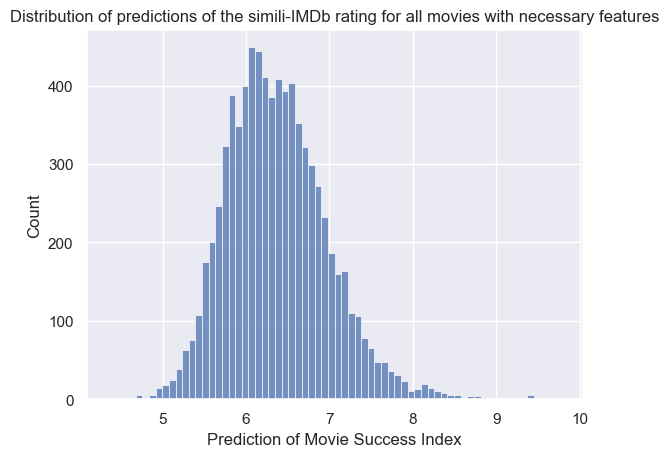

In [18]:
############################### Predictions of the entire dataset #########################################
Y = y_predicted_full

# printing min and max predicted values
Y_min, Y_max = min(Y), max(Y)
print(f'The minimum predicted Success Index : {Y_min:.2f}')
print(f'The maximum predicted Success Index : {Y_max:.2f}')

###################################### Plotting predictions #########################################
sns.histplot(data=Y)
plt.xlabel('Prediction of Movie Success Index')
plt.title('Distribution of predictions of the simili-IMDb rating for all movies with necessary features')
plt.show()



We cannot consider that the resulting predictions are correctly predicting the IMDB ratings. However, the fitted linear prediction gives a nice idea of the relative impact of all parameters on the sucess of movies. Thus, we can use this fitted model to predict the Movie Success Index, which will be a metric that could help comparing movies' sucess. 

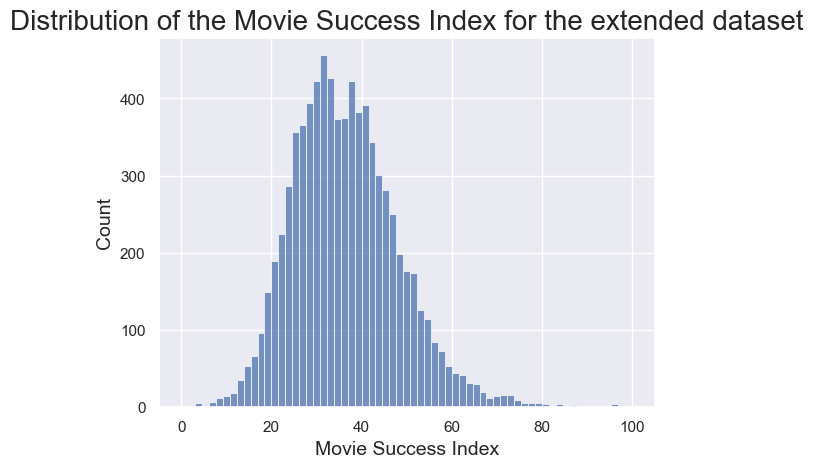

In [19]:
################################ Scaling results from 0 to 100% ################################
def prediction_to_MSI(datapoint, min, max, alpha=0.05):
    '''
    For a single prediction value, given the min and max of the distribution, 
    alpha (between 0 and 1, recommended is 0.15) is the percentage of the calculated interval that we exclude from the interval of predictions. 
    This is to protect the MSI of the effect of outliers that would squish the index.

    returns the scaled Movie Sucess Index (MSI) of that point between 0 and 100%
    the result is round at 2 digits.
    '''
    # original range
    range= max-min
    # Adjusted range for the outliers
    range_ = range*(1-alpha)

    # Adjusted min and max for the outliers
    min_, max_=min+range*alpha/2, max-range*alpha/2

    # calculate MSI in the corresponding reduced range (between 0 and 100)
    MSI= round((datapoint-min_)*100/(range_),2)

    # Set outliers to 0 or 100
    if MSI>0 and MSI<100 :
        return round((datapoint-min_)*100/(range_),2)
    elif MSI<0 :
        #print(0)
        return 0
    else :
        #print(100)
        return 100

def array_of_predictions_to_MSI(predictions, alpha):
    '''For an entire array of predictions, calculates the min and max between those the MSI is scaled.
    calls the function prediction_to_MSI for each prediction

    Alpha refers to the dropped percentage of the prediction's range. 
    This is to adapat the resulting MSI range avoid having all values in the center of the range 0 - 100.
    The predictions between the alpha/2 and 100-alpha/2 quantiles are kept.

    Returns the array with the calculated MSI for the whole dataset.
    '''
    Y_min, Y_max = min(predictions), max(predictions)
    # calculate MSI for each datapoint
    return predictions.apply(lambda x : prediction_to_MSI(x, Y_min, Y_max, alpha))

Y_adjusted=array_of_predictions_to_MSI(Y, 0.05)
#print(array_of_predictions_to_MSI(Y, 0.05))

################################# Plotting Movie Success Index  #########################################
sns.histplot(data=array_of_predictions_to_MSI(Y, 0.05))
plt.xlabel('Movie Success Index', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of the Movie Success Index for the extended dataset', fontsize=20)
plt.savefig('data/plots_website/MSI_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

index en pourcentage : mettre l'index entre 0 et 100. Utiliser les quantiles de la distribution totale des predictions des films : le 2.5% quantile est index=0%, le 97.5% qauntile est index=100%

ajouter les acteurs, calculer les prédictions pour tous les films pour trouver les quantiles. remettre à l'échelle l'index entre les bounds correspondants aux quantiles.

faire cross validation pour savoir l'accuracy de la linear regression sur IMDB. mais l'index résultant de tout le process sera différent du IMDB.

The calculated p-value is 1.08e-32.
The difference in means is statistically significant for an alpha-level of 0.05.
Mean MSI for total/partially US movies : 35.86
Mean MSI for rest-of-the-world movies : 40.26


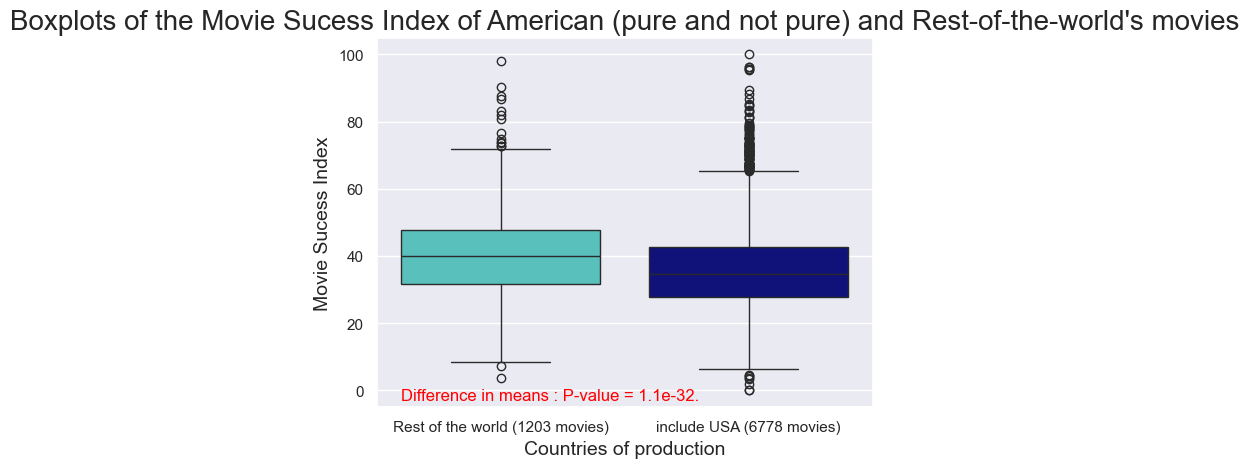

In [28]:
movies_MSI=movie_mtd_topredict
movies_MSI['MSI']=Y_adjusted

######################################## Statistical test ##############################################
# Are the means significantly different ?
# Null hypothesis HO: the means of the two populations (US movies (pure or not) and Rest-of-the-world's movies) are not significantly different.
# Alternative hypotehsis HA: the means of the two populations are significantly different.

alpha=0.05
#statistic, p_value=ttest_ind(movie_mtd[movie_mtd['english available']==1]['box_office'].dropna(), movie_mtd[movie_mtd['english available']==0 ]['box_office'].dropna())
statistic, p_value=ttest_ind(movies_MSI[movies_MSI['united states of america']==1]['MSI'], movies_MSI[movies_MSI['united states of america']==0]['MSI'])
print(f'The calculated p-value is {p_value:.2e}.')
if p_value<alpha :
    print(f'The difference in means is statistically significant for an alpha-level of {alpha}.')
else :
    print(f'The difference in means is NOT statistically significant for an alpha-level of {alpha}.')


##################################### Plot ############################################################

#movies_MSI.columns[50:100]
ax=sns.boxplot(movies_MSI, y='MSI', x='united states of america', palette=['mediumturquoise','darkblue'])
plt.title("Boxplots of the Movie Sucess Index of American (pure and not pure) and Rest-of-the-world's movies", fontsize=20)
print(f'Mean MSI for total/partially US movies : {movies_MSI[movies_MSI["united states of america"]==1]["MSI"].mean():.2f}')
print(f'Mean MSI for rest-of-the-world movies : {movies_MSI[movies_MSI["united states of america"]==0]["MSI"].mean():.2f}')
ax.text(0.8, -3, f'Difference in means : P-value = {p_value:.1e}.', ha='right', fontsize=12, color='red')
ax.set_xticklabels([f'Rest of the world ({len(movies_MSI[movies_MSI["united states of america"]==0])} movies)', f'include USA ({len(movies_MSI[movies_MSI["united states of america"]==1])} movies)'])
plt.xlabel('Countries of production', fontsize=14)
plt.ylabel('Movie Sucess Index', fontsize=14)
plt.savefig('data/plots_website/MSI_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
################################### Interactive plotting #######################################
'''

# Create a column for the region of the world
movies_MSI["Region"] = movies_MSI["united states of america"].apply(
    lambda x: "Americain" if x == 1 else "Rest of the World"
)

# Create the boxplots, one per region
fig = px.box(movies_MSI, y="MSI", x="Region", 
    color="Region", 
    color_discrete_map={
        "Rest of the World": "mediumturquoise", 
        "Americain": "darkblue"
    },
    title="Boxplots of the Movie Success Index of American (only and partially) and Rest-of-the-world's Movies"
)

# Add annotations
fig.add_annotation(
    x=0.5, 
    y=movies_MSI["MSI"].max(), 
    text=f"Difference in means: p-value = {p_value:.1e}",
    showarrow=False,
    font=dict(size=12, color="red"),
    align="right"
)


# Update x-axis tick labels
fig.update_xaxes(
    ticktext=[
        f"Rest of the World ({len(movies_MSI[movies_MSI['united states of america'] == 0])} movies)", 
        f"American ({len(movies_MSI[movies_MSI['united states of america'] == 1])} movies)"
    ],
    tickvals=["Rest of the World", "Americain"]
)

fig.update_layout(
    xaxis_title="Region of production",
    yaxis_title="Movie Success Index",
    title="Movie Success Index for Americain (totally and partially) and Rest-of-the-world's movies",
    title_x=0.47,  # Move the title to the right
    # resize the figure for the display
    autosize=True,
    margin=dict(l=0, r=200, t=50, b=50),
    legend_title="Regions of origin",
    # adjust legend position
    legend=dict(
        x=1.15,  
        y=0.5,  
        xanchor='center',  
        yanchor='middle',
        title="Region of production", 
        font=dict(color="black")   
    ),
    # change color of the writings to black
    title_font=dict(color="black"),  
    font=dict(color="black"),  
)  
# save the figure
fig.write_html("interactive_boxplot_MSI.html")

fig.show()

'''

'\n\n# Create a column for the region of the world\nmovies_MSI["Region"] = movies_MSI["united states of america"].apply(\n    lambda x: "Americain" if x == 1 else "Rest of the World"\n)\n\n# Create the boxplots, one per region\nfig = px.box(movies_MSI, y="MSI", x="Region", \n    color="Region", \n    color_discrete_map={\n        "Rest of the World": "mediumturquoise", \n        "Americain": "darkblue"\n    },\n    title="Boxplots of the Movie Success Index of American (only and partially) and Rest-of-the-world\'s Movies"\n)\n\n# Add annotations\nfig.add_annotation(\n    x=0.5, \n    y=movies_MSI["MSI"].max(), \n    text=f"Difference in means: p-value = {p_value:.1e}",\n    showarrow=False,\n    font=dict(size=12, color="red"),\n    align="right"\n)\n\n\n# Update x-axis tick labels\nfig.update_xaxes(\n    ticktext=[\n        f"Rest of the World ({len(movies_MSI[movies_MSI[\'united states of america\'] == 0])} movies)", \n        f"American ({len(movies_MSI[movies_MSI[\'united states of

https://plotly.com/python/box-plots/

## MSI over time ?

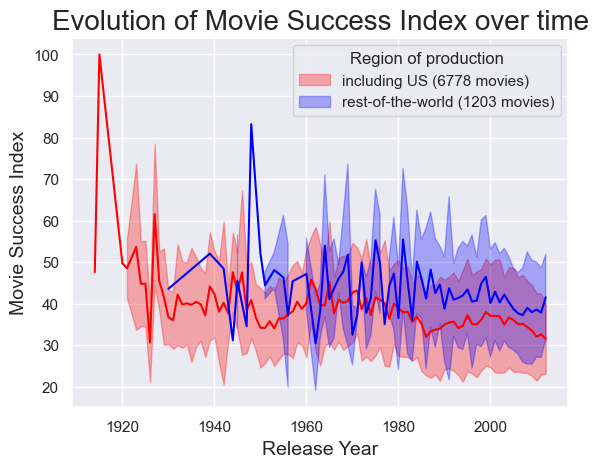

In [22]:
#sns.scatterplot(movies_MSI, x='release_year', y='MSI')
US_MSI=movies_MSI[movies_MSI['united states of america']==1]
non_US_MSI=movies_MSI[movies_MSI['united states of america']==0]
labels=[f'including US ({len(US_MSI)} movies)', f'rest-of-the-world ({len(non_US_MSI)} movies)']

for data, color, label in zip([US_MSI,non_US_MSI], ['red', 'blue'], labels):
    means=data.groupby('release_year').mean()
    std=data.groupby('release_year')['MSI'].std()
    sns.lineplot(means, x='release_year', y='MSI', color=color)
    #years=np.arange(movies_MSI['release_year'].min(), movies_MSI['release_year'].max()+1, 1)
    years=np.sort(data['release_year'].unique())
    plt.fill_between(years, np.array(means['MSI']-std), np.array(means['MSI']+std), color=color, alpha=0.3, label=label)

plt.title('Evolution of Movie Success Index over time', fontsize=20)
plt.legend(title='Region of production')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Movie Success Index', fontsize=14)
plt.savefig('data/plots_website/MSI_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()